# Projeto II - Futuro dos dados e aplicação de Big Data

## Introdução ao projeto

Com a evolução da busca por uma maior eficiência nos ajustes (setups) das máquinas para produção de diferentes itens afim de reduzir de custos por falhas, venho propor uma maneira de agrupamento e distinção de itens por suas complexidades.

### Sobre a base de dados
A base de dados contém uma lista de aproximadamente 150 itens, de um setor especifico da empresa.

Contém as informações por item
- numero de ferramentas utilizadas, 
- custo total das ferramentas, 
- quantidade produzida (últimos 6 meses),
- frequencia média (últimos 6 meses).

#### Sobre o método de agrupamento escolhido
**kmeans**
é um método de segregar em torno de centros diversos dados, particionando observações dentre k grupos onde cada observação pertence ao grupo mais próximo da média.

## Importando as dependências do projeto e carregando o dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15,9)})

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/tmowes/projeto_II/main/setup-tools-raw.csv') # para rodar csv do github
# df = pd.read_csv('setup-tools-raw.csv') # para rodar csv local

In [4]:
df.head()

,Id,Número de ferramentas,Custo total do setup,Total produzida 6 meses,Frequencia 6 meses
0,217yjmmvzqt,4,613,196,5
1,ygkxfwnnwt,5,804,271,9
2,n8mezlecydi,4,613,844,10
3,7lw38g95jxt,8,1157,3534,10
4,npv1rfcxolo,7,875,32,3


### Limpeza de registros nulos ou invalidos

In [5]:
df.isnull().sum()

Id                         0
Número de ferramentas      0
Custo total do setup       0
Total produzida 6 meses    0
Frequencia 6 meses         0
dtype: int64

### Checando os tipo dos registros

In [6]:
print(df.shape)
print('-------')
df.info()

(157, 5)
-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Id                       157 non-null    object
 1   Número de ferramentas    157 non-null    int64 
 2   Custo total do setup     157 non-null    int64 
 3   Total produzida 6 meses  157 non-null    int64 
 4   Frequencia 6 meses       157 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 6.3+ KB


## Iniciando a analise estatística

In [7]:
df.describe()

,Número de ferramentas,Custo total do setup,Total produzida 6 meses,Frequencia 6 meses
count,157.000000,157.000000,157.000000,157.000000
mean,5.566879,855.318471,3293.630573,8.414013
std,1.882013,281.708069,13842.136120,15.513867
min,4.000000,613.000000,1.000000,1.000000
25%,4.000000,613.000000,23.000000,2.000000
50%,5.000000,731.000000,155.000000,4.000000
75%,7.000000,1027.000000,955.000000,9.000000
max,10.000000,1530.000000,112249.000000,116.000000


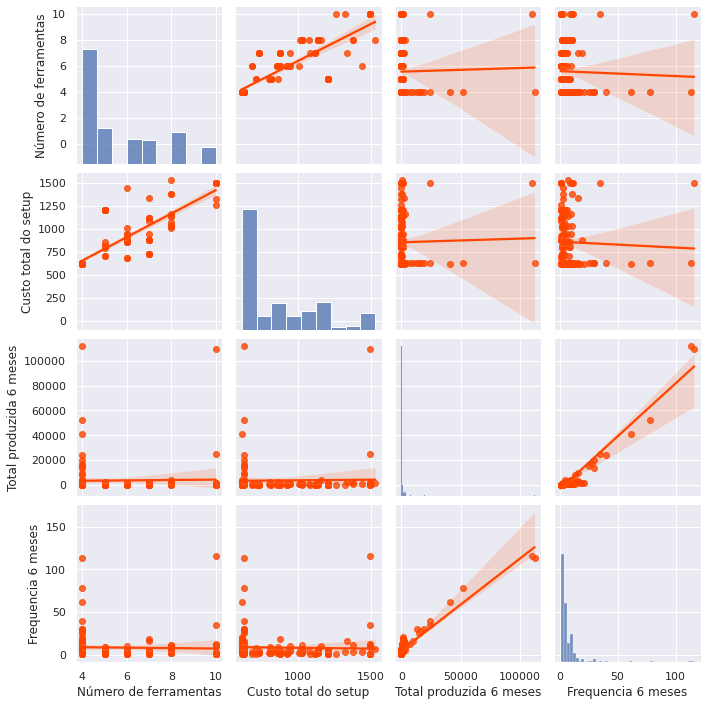

In [8]:
sns.pairplot(df, kind='reg', plot_kws={'color':'orangered'})

### Identificando e removendo outliers

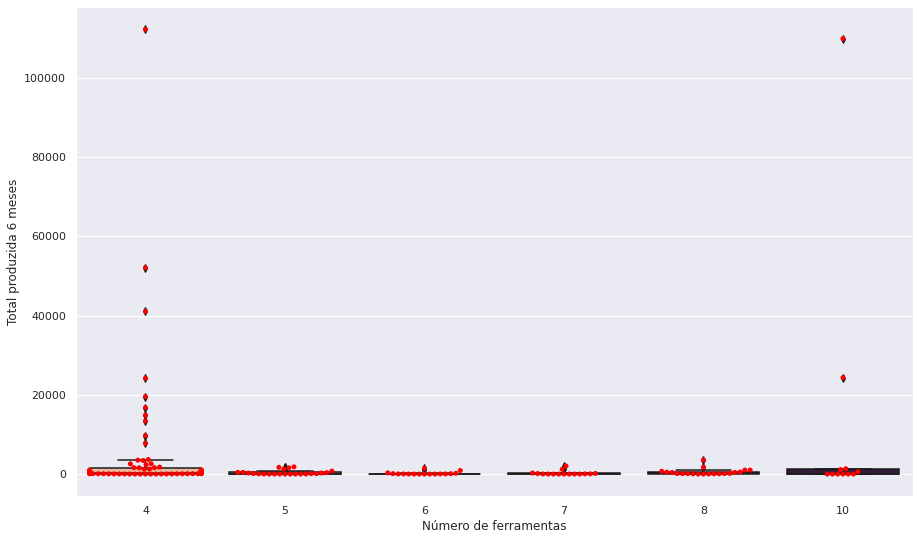

In [9]:
ax = sns.boxplot(x='Número de ferramentas', y='Total produzida 6 meses', data=df, palette='rocket_r')
ax = sns.swarmplot(x='Número de ferramentas', y='Total produzida 6 meses', data=df, color='red')

Como podemos perceber no gráfico acima existe alguns itens com valores acima do desvio padrão, para não comprometer o restante da análise irei remover esses itens.

In [10]:
df = df[df['Total produzida 6 meses'] < 4000]

In [11]:
df.shape

(145, 5)

O conjunto de dados sem outliers ficou com:
- 145 itens e 4 atributos mais o ID unico.

### Analisando as distribuições dos atributos brutos

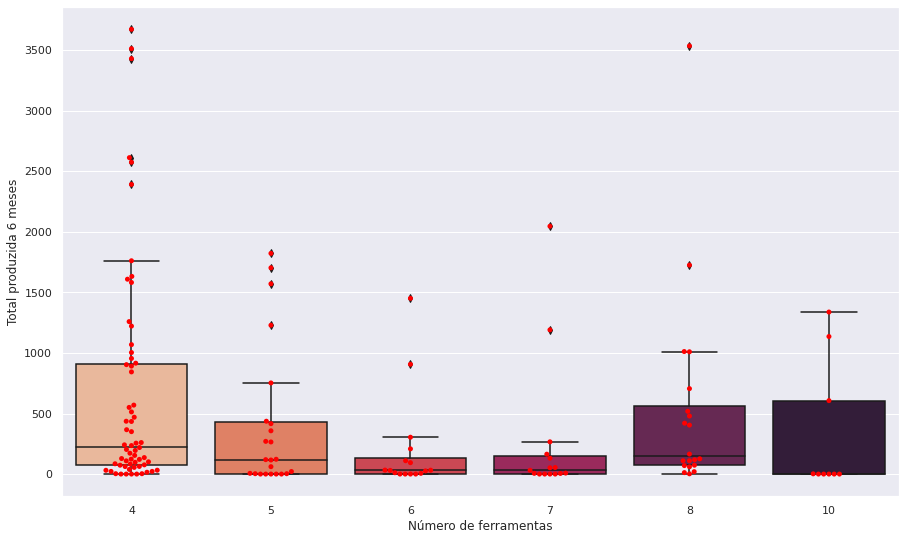

In [12]:
ax = sns.boxplot(x='Número de ferramentas', y='Total produzida 6 meses', data=df, palette='rocket_r')
ax = sns.swarmplot(x='Número de ferramentas', y='Total produzida 6 meses', data=df, color='red')

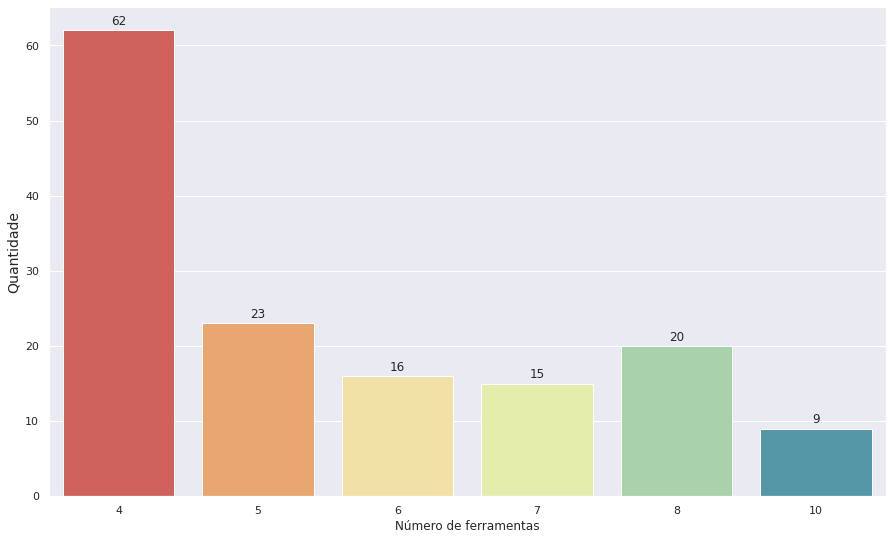

4     0.427586
5     0.158621
8     0.137931
6     0.110345
7     0.103448
10    0.062069
Name: Número de ferramentas, dtype: float64


In [13]:
plt.figure(figsize=(15,9))
splot=sns.countplot(x='Número de ferramentas', data=df, palette='Spectral')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel("Quantidade", size=14)
plt.show()

print(df['Número de ferramentas'].value_counts() / len(df))

- A maioria dos itens tem a quantidade mínima de 4 ferramentas 42%. (0.427586)
- Nenhum dos itens tem 9 ferramentas 0%. (0.0)
- A quantidade máxima de ferramentas é de 10 ferramentas 6%. (0.062069)

[0.4896551724137931, 0.2, 0.15172413793103448, 0.0896551724137931, 0.07586206896551724]


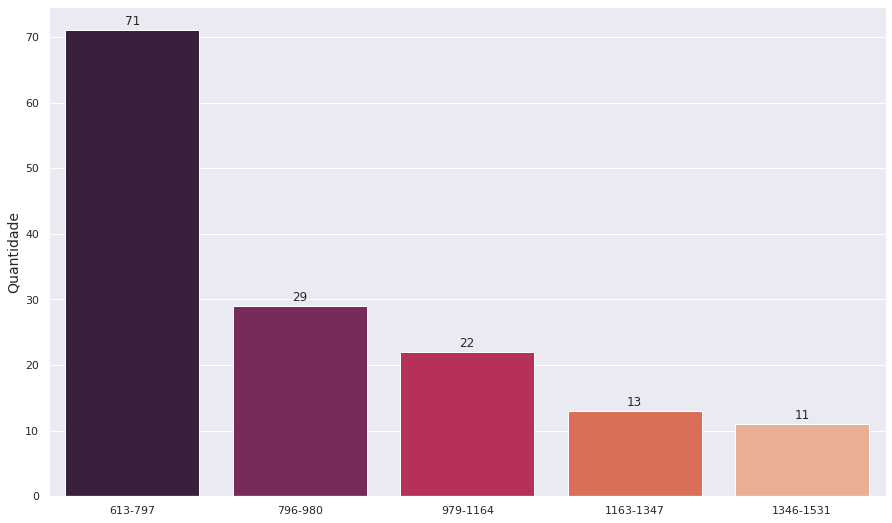

In [14]:
min_cost = df['Custo total do setup'].min()
max_cost = df['Custo total do setup'].max()
cost_group = (df['Custo total do setup'].max() - df['Custo total do setup'].min()) / 5

setup_cost_x = []
setup_cost_y = []
range_percent = []

for i in range(5):
  total_in_range = len(df['Custo total do setup'][(df['Custo total do setup'] >= cost_group * (i) + min_cost)&(df['Custo total do setup'] <= cost_group * (i+1) + min_cost+1)].values)
  setup_cost_x.append(str(int(cost_group * (i) + min_cost))+'-'+str(int(cost_group * (i+1) + min_cost+1)))
  setup_cost_y.append(total_in_range)
  range_percent.append(total_in_range / len(df))

print(range_percent)

plt.figure(figsize=(15,9))
splot=sns.barplot(x=setup_cost_x, y=setup_cost_y, palette='rocket')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel("Quantidade", size=14)
plt.show()


- A maioria dos itens tem o custo entre 613-797 reais 49%. (0.48965)
- A quantidade de é menor itens conforme o aumento do custo do setup.

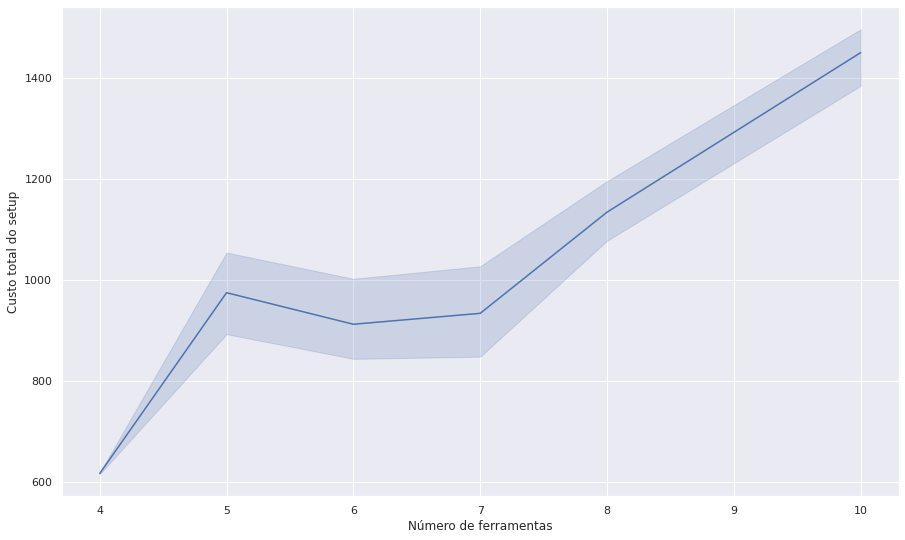

In [15]:
ax = sns.lineplot(x='Número de ferramentas', y='Custo total do setup', data=df)

Existem uma tendência de aumento no custo do setup conforme o aumenta a quantidade de ferramentas necessárias.

Podemos observar um platô no custo do setup entre 5 e 7 ferramentas

Consolidar a taxa de frequência dividindo o total produzido pela frequência dos últimos 6 meses

In [16]:
df['Taxa de Frequência'] = df['Total produzida 6 meses'] / df['Frequencia 6 meses']
df.drop(axis=1, columns=['Total produzida 6 meses','Frequencia 6 meses'], inplace=True)

In [17]:
print(df.shape)
df.head()

(145, 4)


,Id,Número de ferramentas,Custo total do setup,Taxa de Frequência
0,217yjmmvzqt,4,613,39.200000
1,ygkxfwnnwt,5,804,30.111111
2,n8mezlecydi,4,613,84.400000
3,7lw38g95jxt,8,1157,353.400000
4,npv1rfcxolo,7,875,10.666667


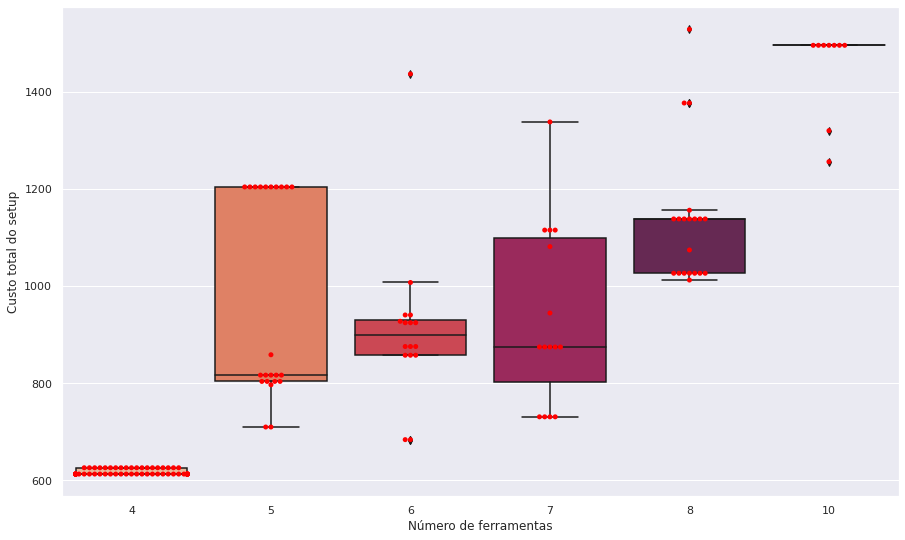

In [18]:
ax = sns.boxplot(x='Número de ferramentas', y='Custo total do setup', data=df, palette='rocket_r')
ax = sns.swarmplot(x='Número de ferramentas', y='Custo total do setup', data=df, color='red')

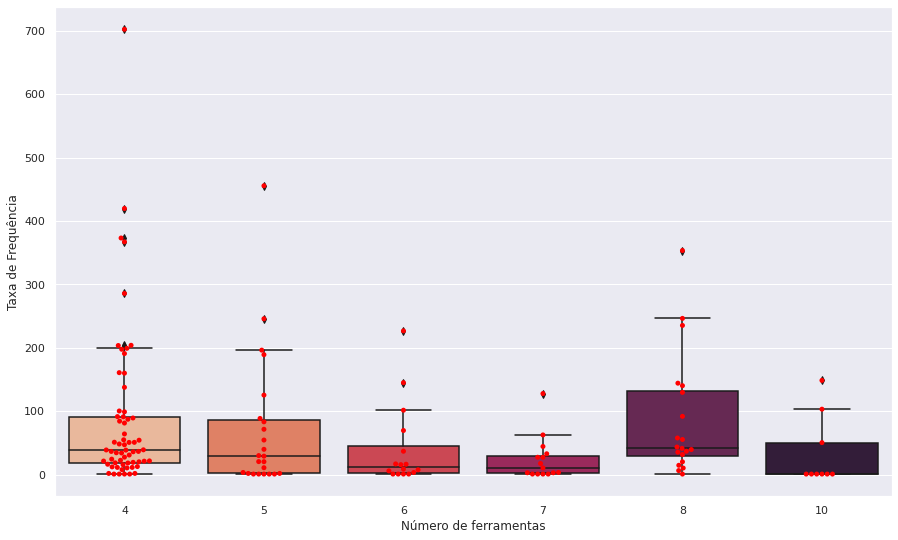

In [19]:
ax = sns.boxplot(x='Número de ferramentas', y='Taxa de Frequência', data=df, palette='rocket_r')
ax = sns.swarmplot(x='Número de ferramentas', y='Taxa de Frequência', data=df, color='red')

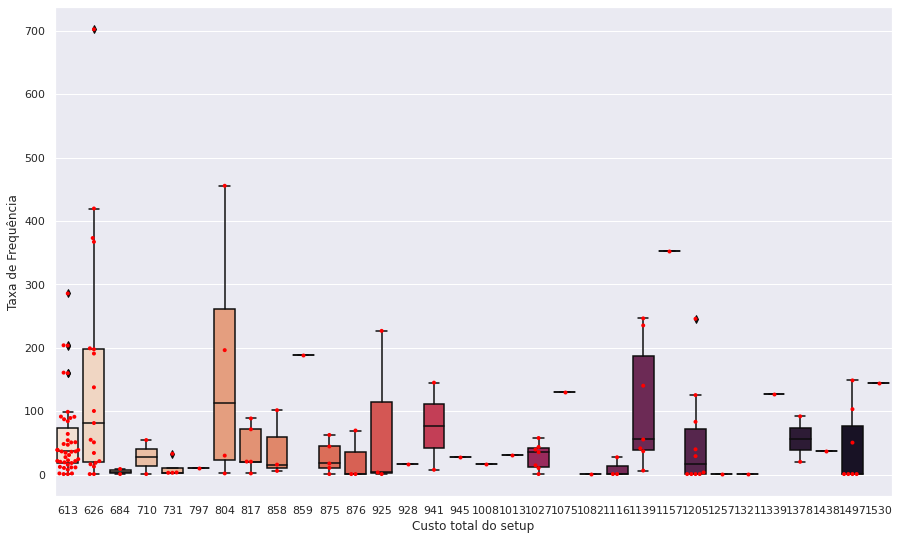

In [20]:
ax = sns.boxplot(x='Custo total do setup', y='Taxa de Frequência', data=df, palette='rocket_r')
ax = sns.swarmplot(x='Custo total do setup', y='Taxa de Frequência', data=df, color='red',size=4)

### Analizando a distibuição dos atributos usando normalização

In [21]:
X = df.iloc[:,[1,2,3]].values
scaler = StandardScaler()
scalerX = scaler.fit_transform(X)

In [22]:
df_scaled = pd.DataFrame(scalerX, columns=['Número de ferramentas','Custo total do setup','Taxa de Frequência'] ) 

In [23]:
df_scaled.shape

(145, 3)

In [24]:
df_scaled.head()

,Número de ferramentas,Custo total do setup,Taxa de Frequência
0,-0.879339,-0.904678,-0.297588
1,-0.334449,-0.211765,-0.385515
2,-0.879339,-0.904678,0.139686
3,1.300219,1.068855,2.742046
4,0.755330,0.045811,-0.573625


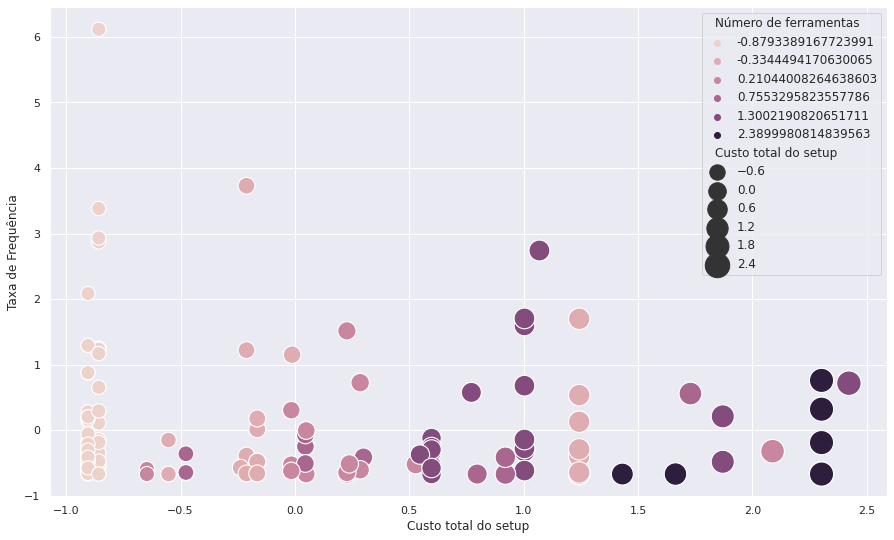

In [25]:
ax = sns.scatterplot(x='Custo total do setup', y='Taxa de Frequência', data=df_scaled, hue='Número de ferramentas', size='Custo total do setup', sizes=(200,600))

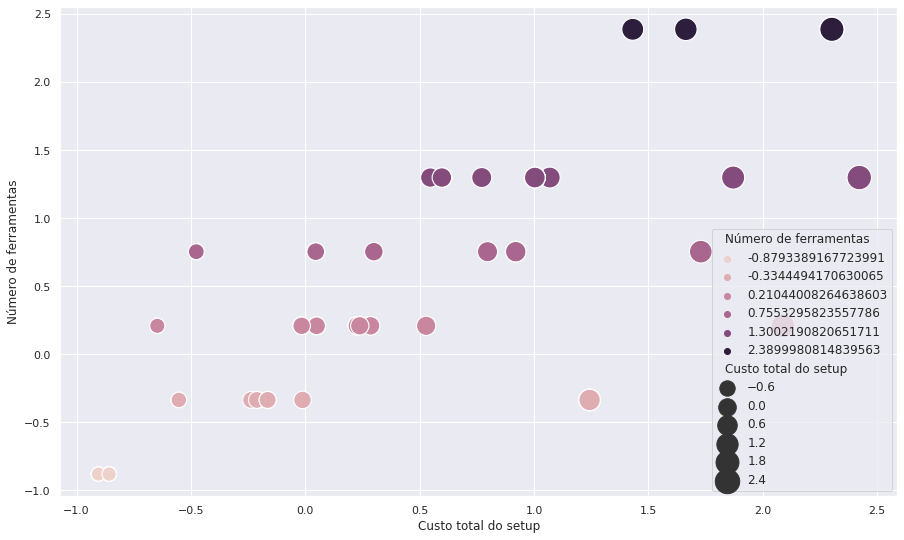

In [26]:
ax = sns.scatterplot(y='Número de ferramentas', x='Custo total do setup', data=df_scaled, hue='Número de ferramentas', size='Custo total do setup', sizes=(200,600))

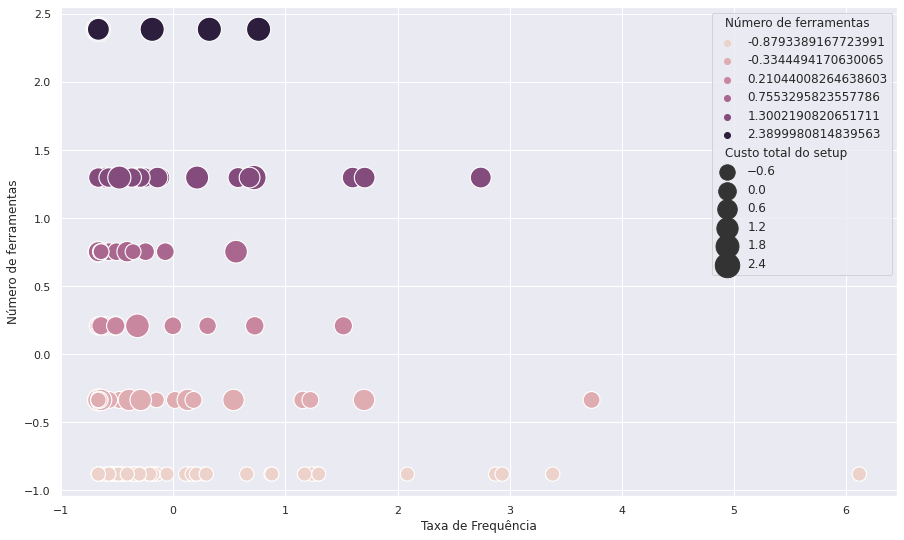

In [27]:
ax = sns.scatterplot(y='Número de ferramentas', x='Taxa de Frequência', data=df_scaled, hue='Número de ferramentas', size='Custo total do setup', sizes=(200,600))

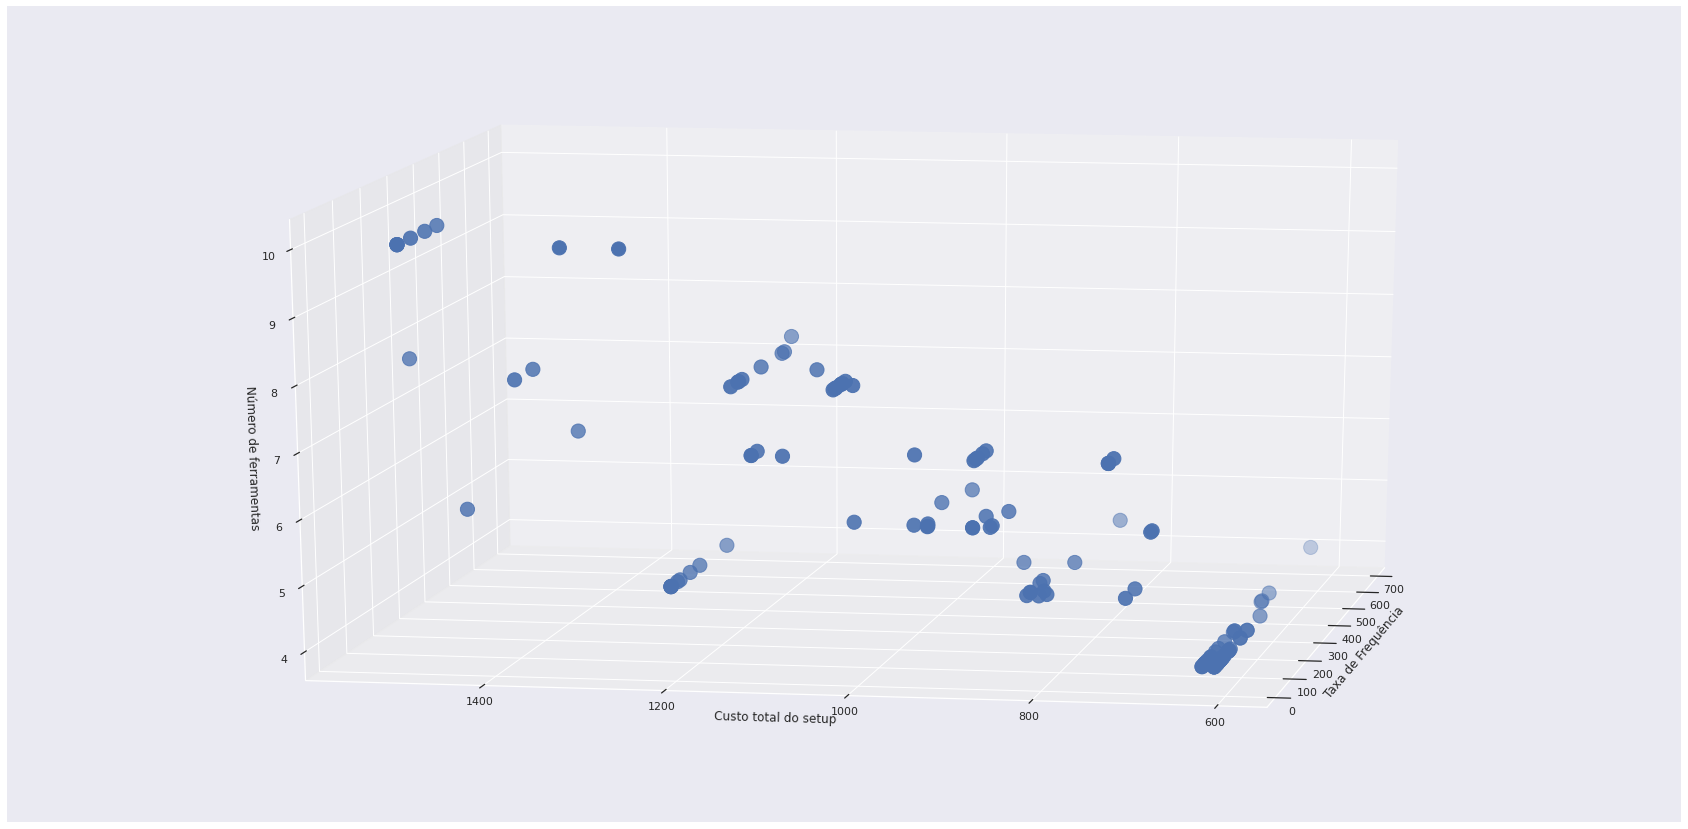

In [28]:
fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(df['Taxa de Frequência'], df["Custo total do setup"], df["Número de ferramentas"], s=200)
ax.view_init(15, 190)

plt.xlabel("Taxa de Frequência")
plt.ylabel("Custo total do setup")
ax.set_zlabel('Número de ferramentas')
plt.show()

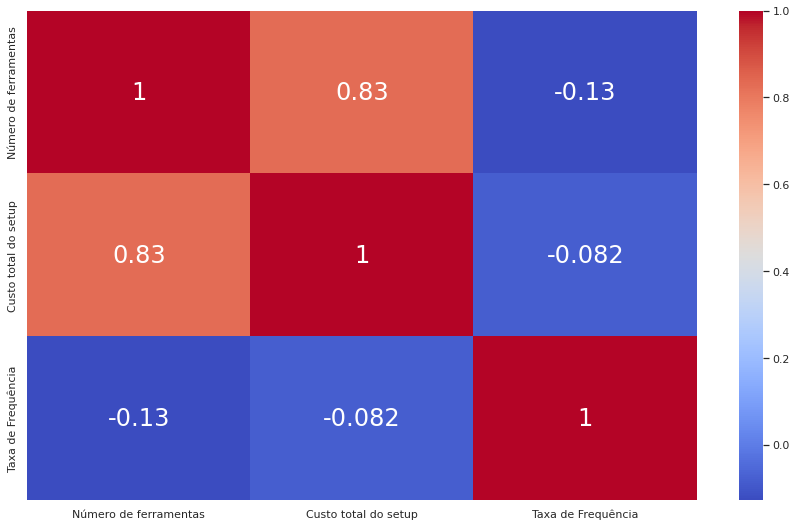

In [29]:
df_scaled_corr = df_scaled.corr()
hm = sns.heatmap(df_scaled_corr, annot=True, annot_kws={'size':24}, cmap='coolwarm')

Conforme podemos observar no heatmap de correlação, a taxa de frequencia não tem uma correlação positiva que é necessária para utilizar no agrupamento.

## Utilizando agrupamento com o KMeans

Para desenvolvimento do algoritmo de agrupamento utilizarei somente as seguintes caracteristicas:
- Número de ferramentas
- Custo total do setup

In [30]:
X = df.iloc[:,[1,2]].values

In [31]:
scaler = StandardScaler().fit(X)
scalerX = scaler.transform(X)

In [32]:
wcss = [] # within-cluster sum of squares

In [33]:
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(scalerX)
    wcss.append(kmeans.inertia_)

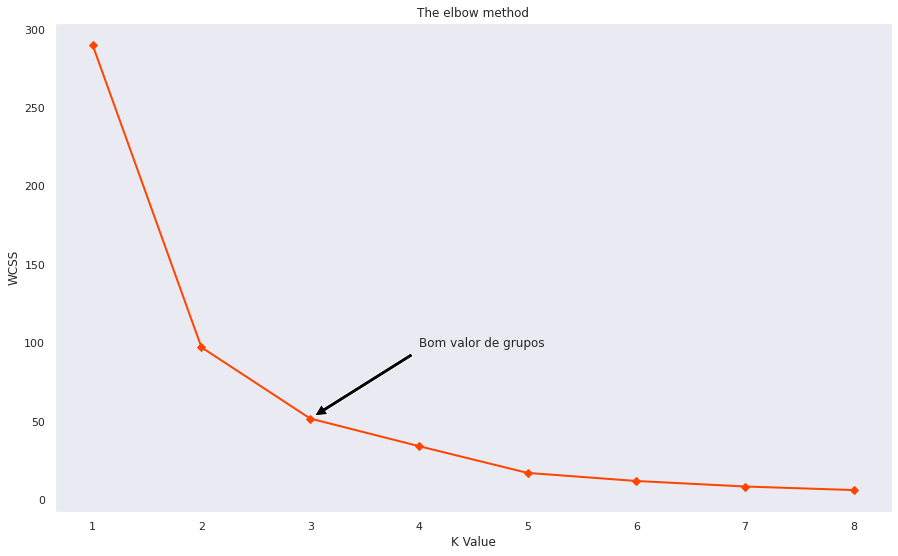

In [34]:
plt.figure(figsize=(15, 9))
plt.grid()
plt.plot(range(1,9), wcss, linewidth=2, color='orangered', marker='D')
plt.annotate('Bom valor de grupos',xy=(3,wcss[2]),xytext=(4,wcss[1]), arrowprops=dict(facecolor='black',shrink=0.04))
plt.title('The elbow method')
plt.xlabel('K Value')
plt.ylabel('WCSS')
plt.show()

Com a utilização do Elbow method podemos definir que 3 grupos consegue apresentar uma boa definição dos dados 

In [35]:
kmeansmodel = KMeans(n_clusters=3, init='k-means++', random_state=0)

In [36]:
y_kmeans = kmeansmodel.fit_predict(scalerX)

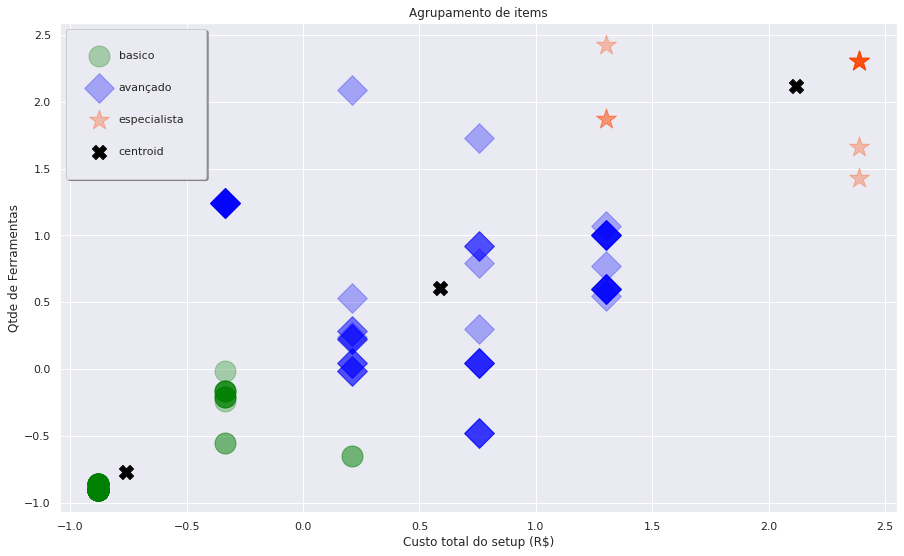

In [37]:
plt.figure(figsize=(15, 9))
plt.scatter(scalerX[y_kmeans == 0,0], scalerX[y_kmeans == 0,1], s= 440,alpha=0.3, c="green", label='basico')
plt.scatter(scalerX[y_kmeans == 2,0], scalerX[y_kmeans == 2,1], s= 440,alpha=0.3, c="blue", label='avançado',marker='D')
plt.scatter(scalerX[y_kmeans == 1,0], scalerX[y_kmeans == 1,1], s= 440,alpha=0.3, c="orangered", label='especialista',marker='*')
plt.scatter( 
  x=kmeansmodel.cluster_centers_[:,0],
  y=kmeansmodel.cluster_centers_[:,1],
  color="black",
  marker="X",
  label='centroid',
  s=200)
plt.title('Agrupamento de items')
plt.xlabel('Custo total do setup (R$)')
plt.ylabel('Qtde de Ferramentas')
plt.legend(loc='upper left', fancybox=True, labelspacing=2, framealpha=1, shadow=True, borderpad=2)
plt.show()

In [38]:
centers = scaler.inverse_transform(kmeansmodel.cluster_centers_)

In [39]:
df['result'] = y_kmeans

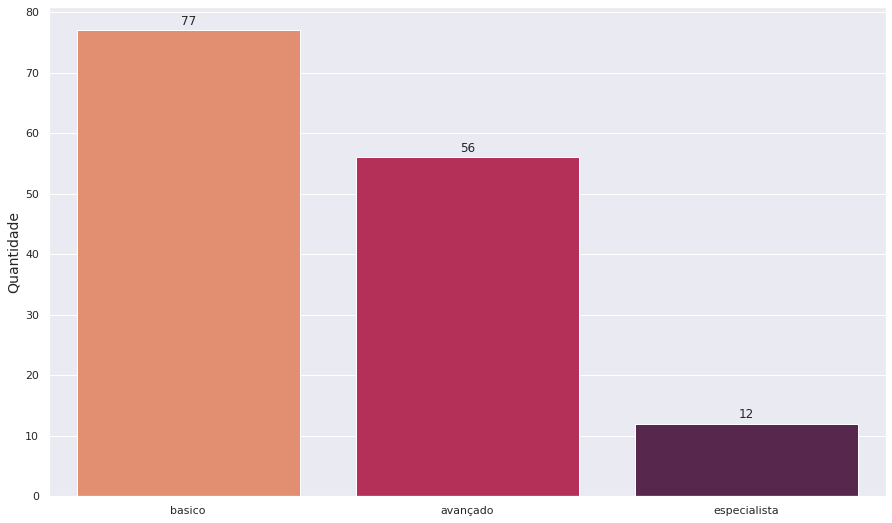

In [40]:
setup_basic = df["result"][(df["result"] == 0)]
setup_advanced = df["result"][(df["result"] == 2)]
setup_specialist = df["result"][(df["result"] == 1)]

setup_label_x = ['basico', 'avançado', 'especialista']
setup_label_y = [len(setup_basic.values),len(setup_advanced.values),len(setup_specialist.values)] 

plt.figure(figsize=(15,9))
splot=sns.barplot(x=setup_label_x, y=setup_label_y, palette='rocket_r')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel("Quantidade", size=14)
plt.show()

Conseguimos definir os itens em seus respectivos grupos:
- básico com 77 itens.
- básico com 56 itens.
- especialista com 12 itens.


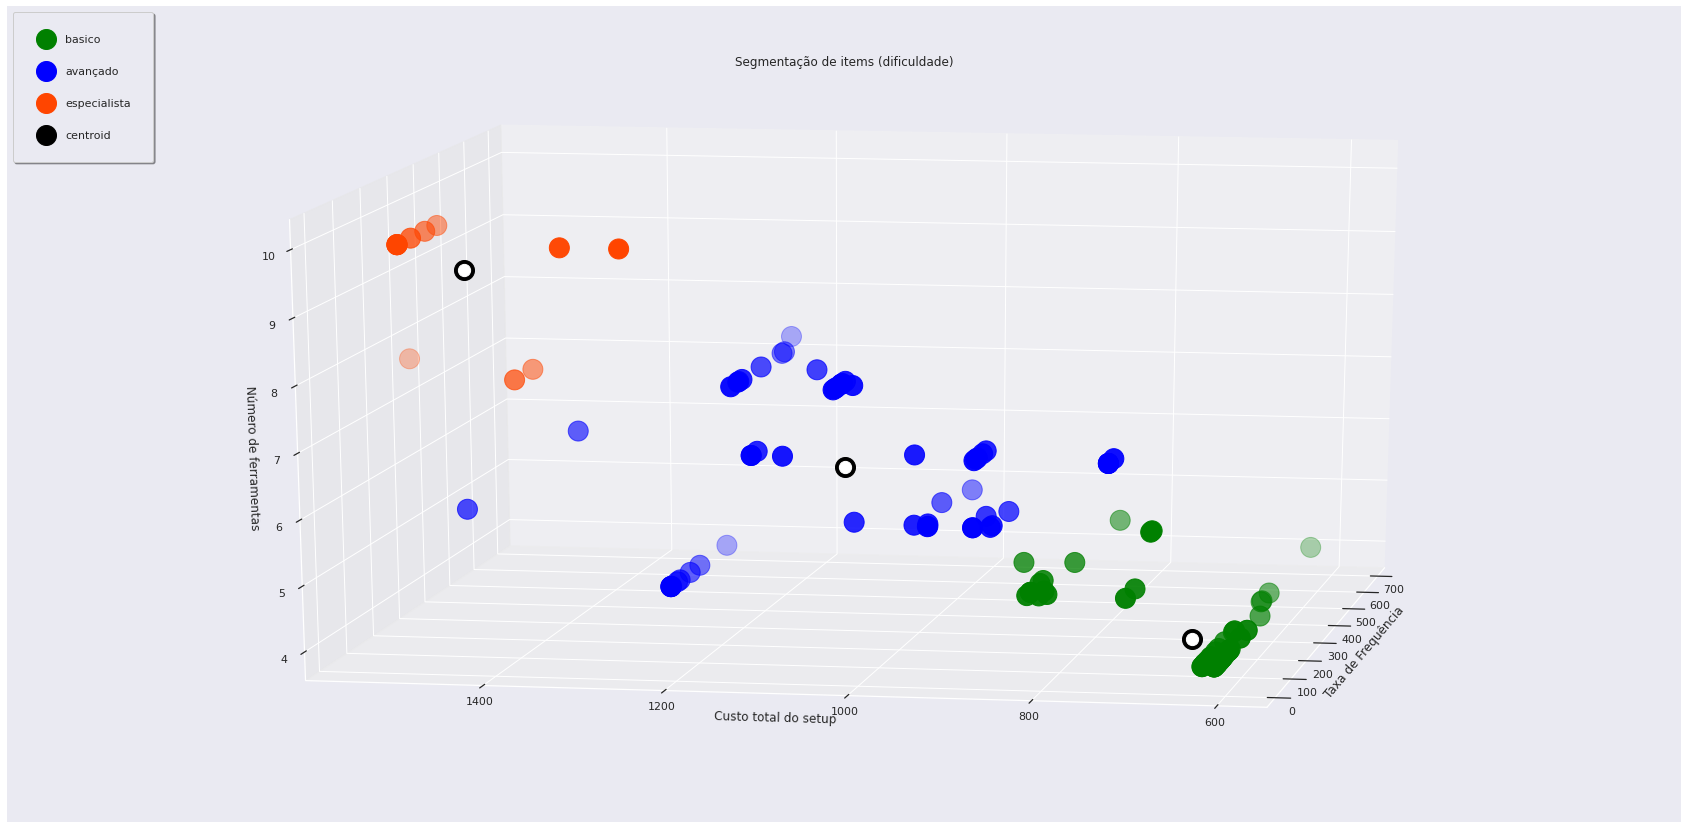

In [41]:
fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(df['Taxa de Frequência'][df.result == 0], df["Custo total do setup"][df.result == 0], df["Número de ferramentas"][df.result == 0], c='green', s=400, label='basico')
ax.scatter(df['Taxa de Frequência'][df.result == 2], df["Custo total do setup"][df.result == 2], df["Número de ferramentas"][df.result == 2], c='blue', s=400, label='avançado')
ax.scatter(df['Taxa de Frequência'][df.result == 1], df["Custo total do setup"][df.result == 1], df["Número de ferramentas"][df.result == 1], c='orangered', s=400, label='especialista')

ax.scatter(df['Taxa de Frequência'].mean(), centers[:,1], centers[:,0], c='black', depthshade=False, s=400, label='centroid')
ax.scatter(df['Taxa de Frequência'].mean(), centers[:,1], centers[:,0], c='white', depthshade=False, s=150)

ax.view_init(15, 190)

plt.title('Segmentação de items (dificuldade)')
plt.xlabel("Taxa de Frequência")
plt.ylabel("Custo total do setup")
ax.set_zlabel('Número de ferramentas')
plt.legend(loc='upper left', fancybox=True, labelspacing=2, framealpha=1, shadow=True, borderpad=2)
plt.show()



Vizualização 3D mostra como os atributos distribuidos em seus respectivos grupos e a posição dos seus centros.

### Salvando dados segmentados para arquivo csv

In [42]:
df.head()

,Id,Número de ferramentas,Custo total do setup,Taxa de Frequência,result
0,217yjmmvzqt,4,613,39.200000,0
1,ygkxfwnnwt,5,804,30.111111,0
2,n8mezlecydi,4,613,84.400000,0
3,7lw38g95jxt,8,1157,353.400000,2
4,npv1rfcxolo,7,875,10.666667,2


In [43]:
df.to_csv('segmented-data.csv')

## Usando o modelo com novas entradas

#### Método utilitário para tratamento de novas entradas


In [44]:
def get_dataframe_averages(
  num_ferramentas = df['Número de ferramentas'].mean(),
  custo_setup = df['Custo total do setup'].mean(),
  taxa_frequencia = df['Taxa de Frequência'].mean()
  ):
    print("Médias dos dados analisados")
    print("Número de ferramentas = %1.f" % num_ferramentas)
    print("Custo total do setup = %2.2f" % custo_setup)
    print("Taxa de Frequência = %2.2f" % taxa_frequencia)
    return num_ferramentas,custo_setup,taxa_frequencia

In [45]:
num_ferramentas,custo_setup,taxa_frequencia = get_dataframe_averages()

Médias dos dados analisados
Número de ferramentas = 6
Custo total do setup = 862.37
Taxa de Frequência = 69.96


#### Nova entrada de dados

In [46]:
# Nova entrada de dados
num_ferramentas = 6
custo_setup = 1550
taxa_frequencia = taxa_frequencia

In [47]:
new_entry_df = pd.DataFrame()
new_entry_df['Número de ferramentas'] = [num_ferramentas]
new_entry_df['Custo total do setup'] =	[custo_setup]
new_entry_df['Taxa de Frequência'] =	[taxa_frequencia]
new_entry_df

,Número de ferramentas,Custo total do setup,Taxa de Frequência
0,6,1550,69.960964


In [48]:
new_entry_X = new_entry_df.iloc[:,[0,1]].values
scaler_new_entry = scaler.transform(new_entry_X)
new_y_kmeans = kmeansmodel.predict(scaler_new_entry)
new_entry_df['result'] = new_y_kmeans

In [49]:
new_entry_df.head()

,Número de ferramentas,Custo total do setup,Taxa de Frequência,result
0,6,1550,69.960964,2


Item novo foi adicionado ao grupo de itens "Avançado".

# Conclusão

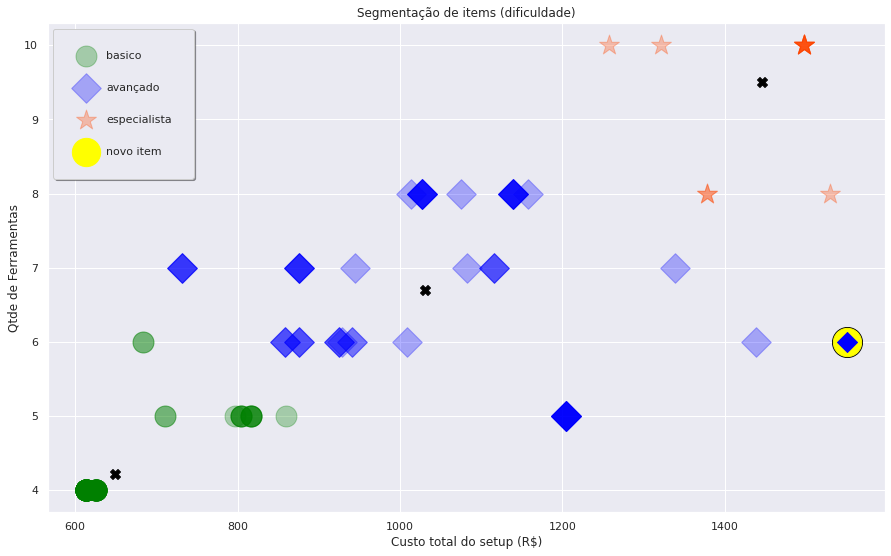

In [50]:
plt.figure(figsize=(15, 9))
plt.scatter(df["Custo total do setup"][df.result == 0], df["Número de ferramentas"][df.result == 0], s= 440,alpha=0.3, c="green", label='basico')
plt.scatter(df["Custo total do setup"][df.result == 2], df["Número de ferramentas"][df.result == 2], s= 440,alpha=0.3, c="blue", label='avançado',marker='D')
plt.scatter(df["Custo total do setup"][df.result == 1], df["Número de ferramentas"][df.result == 1], s= 440,alpha=0.3, c="orangered", label='especialista',marker='*')

plt.scatter(new_entry_df["Custo total do setup"], new_entry_df["Número de ferramentas"], s= 900,alpha=1, c="black")
plt.scatter(new_entry_df["Custo total do setup"], new_entry_df["Número de ferramentas"], s= 800,alpha=1, label='novo item', c="yellow")

plt.scatter(new_entry_df["Custo total do setup"][new_entry_df.result == 0], new_entry_df["Número de ferramentas"][new_entry_df.result == 0], s= 200,alpha=1, c="green")
plt.scatter(new_entry_df["Custo total do setup"][new_entry_df.result == 2], new_entry_df["Número de ferramentas"][new_entry_df.result == 2], s= 200,alpha=1, c="blue",marker='D')
plt.scatter(new_entry_df["Custo total do setup"][new_entry_df.result == 1], new_entry_df["Número de ferramentas"][new_entry_df.result == 1], s= 200,alpha=1, c="orangered",marker='*')

plt.scatter( 
  x=centers[:,1],
  y=centers[:,0],
  color="black",
  marker="X",
  s=100)
plt.title('Segmentação de items (dificuldade)')
plt.xlabel('Custo total do setup (R$)')
plt.ylabel('Qtde de Ferramentas')
plt.legend(loc='upper left', fancybox=True, labelspacing=2, framealpha=1, shadow=True, borderpad=2)
plt.show()

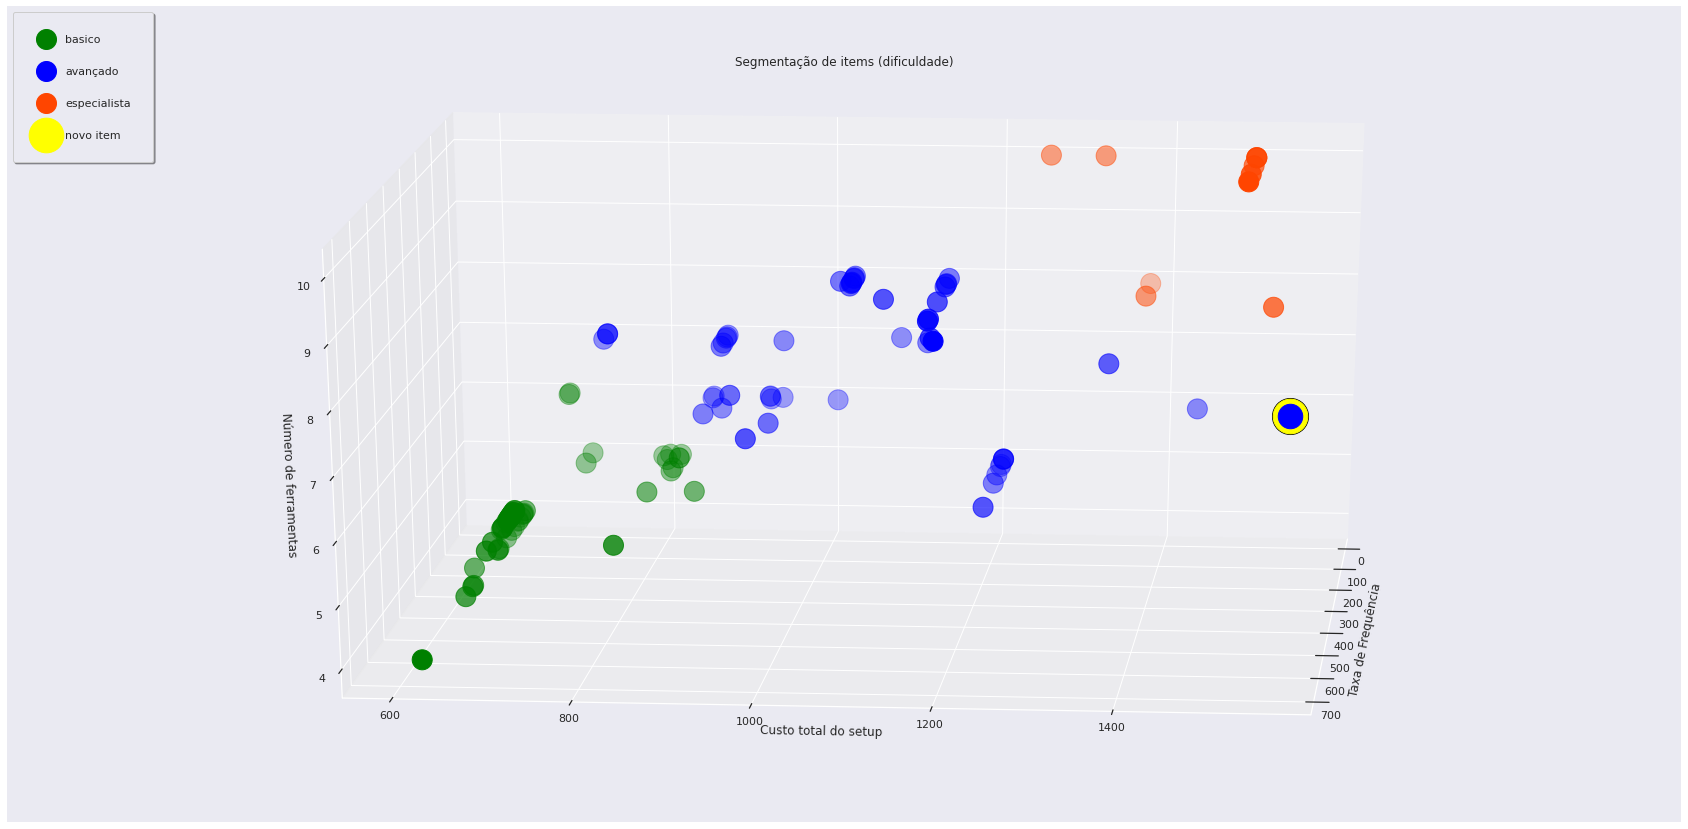

In [51]:
fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(df['Taxa de Frequência'][df.result == 0], df["Custo total do setup"][df.result == 0], df["Número de ferramentas"][df.result == 0], c='green', s=400, label='basico')
ax.scatter(df['Taxa de Frequência'][df.result == 2], df["Custo total do setup"][df.result == 2], df["Número de ferramentas"][df.result == 2], c='blue', s=400, label='avançado')
ax.scatter(df['Taxa de Frequência'][df.result == 1], df["Custo total do setup"][df.result == 1], df["Número de ferramentas"][df.result == 1], c='orangered', s=400, label='especialista')

ax.scatter(new_entry_df['Taxa de Frequência'], new_entry_df["Custo total do setup"], new_entry_df["Número de ferramentas"], c='black', s=1300)
ax.scatter(new_entry_df['Taxa de Frequência'], new_entry_df["Custo total do setup"], new_entry_df["Número de ferramentas"], c='yellow', s=1200, label='novo item')

ax.scatter(new_entry_df['Taxa de Frequência'][new_entry_df.result == 0], new_entry_df["Custo total do setup"][new_entry_df.result == 0], new_entry_df["Número de ferramentas"][new_entry_df.result == 0], c='green', s=600)
ax.scatter(new_entry_df['Taxa de Frequência'][new_entry_df.result == 1], new_entry_df["Custo total do setup"][new_entry_df.result == 1], new_entry_df["Número de ferramentas"][new_entry_df.result == 1], c='orangered', s=600)
ax.scatter(new_entry_df['Taxa de Frequência'][new_entry_df.result == 2], new_entry_df["Custo total do setup"][new_entry_df.result == 2], new_entry_df["Número de ferramentas"][new_entry_df.result == 2], c='blue', s=600)

ax.view_init(20, 5)

plt.title('Segmentação de items (dificuldade)')
plt.xlabel("Taxa de Frequência")
plt.ylabel("Custo total do setup")
ax.set_zlabel('Número de ferramentas')
plt.legend(loc='upper left', fancybox=True, labelspacing=2, framealpha=1, shadow=True, borderpad=2)
plt.show()

Ao segmentar os itens por grupos de dificuldade podemos: 
- Facilitar a alocação de recursos para os ajustes(setup) de máquinas, podemos ver a necessidade de alocar um especialista para ajuste de determinados itens.
- Reduzir tempo de ajustes(setup).
- Reduzir erros em ajustes(setup) mais complexos.

Pendências verificadas:
- Conforme a frequência dos itens deveria ser possível reduzir sua dificuldade e com a repetição e prática o mesmo poderia ter seu grau de dificuldade reduzido.